# 10x heart fit, whole-dataset, no noise


In this notebook, we fit a model with bursty transcription, splicing, and degradation, without integrating a model of technical noise. We analyze the three 10x heart datasets.


## Prerequisites

Load in *Monod*.


In [1]:
import sys
sys.path.insert(0, '/home/ggorin/projects/monod/src/')

In [2]:
import monod
from monod import preprocess, extract_data, cme_toolbox, inference, analysis

## Metadata

Define metadata and directories.


In [3]:
dataset_meta = ['heart_' + x for x in ['1k_v2','1k_v3','10k_v3']]

dataset_names = [x for x in dataset_meta ]  
raw_data_locations = [x for x in dataset_meta]
transcriptome_filepath = '../polyA_ref/gg_200524_mouse_genome_polyA_cum_1'

spliced_layer = 'spliced'
unspliced_layer = 'unspliced'
gene_attr = 'gene_name'
cell_attr = 'barcode'

attribute_names=[(unspliced_layer,spliced_layer),gene_attr,cell_attr]

loom_filepaths = ['/home/ggorin/count_data/loom_10x_kb/'+x+'.loom' for x in raw_data_locations] 
n_datasets = len(loom_filepaths)


In [4]:
dataset_names

['heart_1k_v2', 'heart_1k_v3', 'heart_10k_v3']

## Filtering

Perform a round of filtering based on the knee plot.


In [5]:
import pandas as pd
import numpy as np
import loompy as lp
import matplotlib.pyplot as plt
import scipy


Dataset heart_1k_v2. 
	743 barcodes in loom, 703 pass filter.
Dataset heart_1k_v3. 
	982 barcodes in loom, 976 pass filter.
Dataset heart_10k_v3. 
	7462 barcodes in loom, 7402 pass filter.


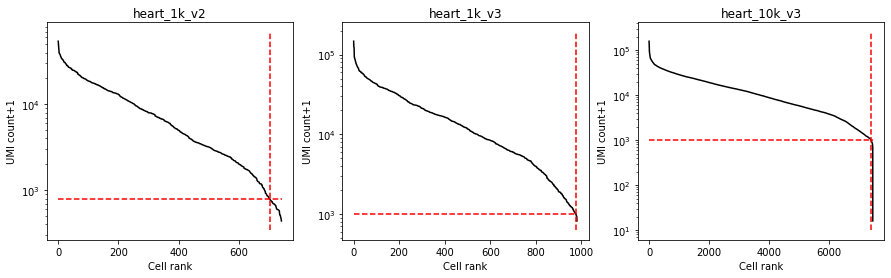

In [6]:
cf = []
thr_lb = [8e2,1e3,1e3]
S_arr = []
U_arr = []
fig1,ax1 = plt.subplots(1,3,figsize=(15,4))

for k in range(len(dataset_meta)):
    filename = loom_filepaths[k ]
    dataset_name = raw_data_locations[k ]
        
    with lp.connect(filename,mode='r') as ds:
        S = ds.layers[spliced_layer][:]
        U = ds.layers[unspliced_layer][:]
        gene_names = ds.ra[gene_attr]
        bcs = ds.ca[cell_attr]
        n_cells = S.shape[1]
        monod.preprocess.knee_plot(S+U,ax1[k],viz=True,thr=thr_lb[k])
        cf_ = ((S+U).sum(0)>thr_lb[k])
        
        print(f'Dataset {dataset_name}. \n\t{len(bcs)} barcodes in loom, {cf_.sum()} pass filter.')
#         
        S_arr.append(S)
        U_arr.append(U)

        cf.append(cf_)

    ax1[k].set_title(dataset_name)


## Preprocessing

Create a batch and select genes to analyze.


In [7]:
import logging, sys
logging.basicConfig(stream=sys.stdout)
log = logging.getLogger()
log.setLevel(logging.INFO)

INFO:root:Beginning data preprocessing and filtering.
INFO:root:Directory ./fits/gg_221119_025_heart_noisefree_1 created.
INFO:root:Dataset: heart_1k_v2
INFO:root:703 cells detected.
INFO:root:32285 features observed, 32005 match genome annotations. 31649 were unique.
INFO:root:2612 genes retained after expression filter.
INFO:root:Directory ./fits/gg_221119_025_heart_noisefree_1/heart_1k_v2 created.
INFO:root:Dataset: heart_1k_v3
INFO:root:976 cells detected.
INFO:root:32285 features observed, 32005 match genome annotations. 31649 were unique.
INFO:root:6780 genes retained after expression filter.
INFO:root:Directory ./fits/gg_221119_025_heart_noisefree_1/heart_1k_v3 created.
INFO:root:Dataset: heart_10k_v3
INFO:root:7402 cells detected.
INFO:root:32285 features observed, 32005 match genome annotations. 31649 were unique.
INFO:root:8408 genes retained after expression filter.
INFO:root:Directory ./fits/gg_221119_025_heart_noisefree_1/heart_10k_v3 created.
INFO:root:Total of 2500 genes

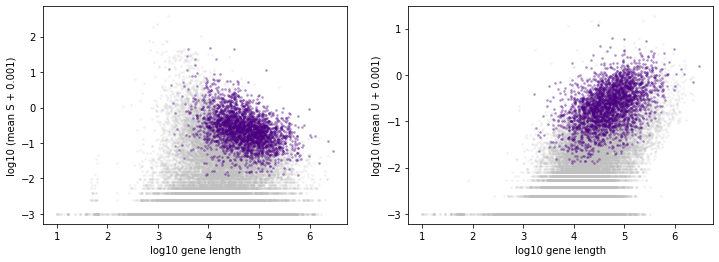

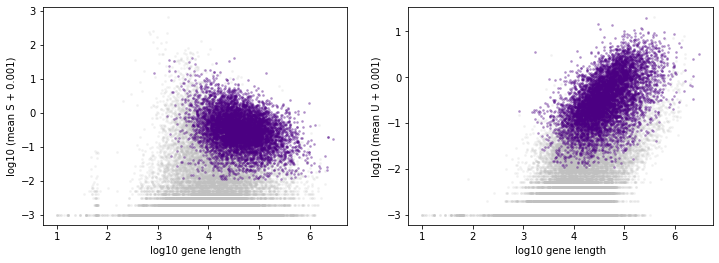

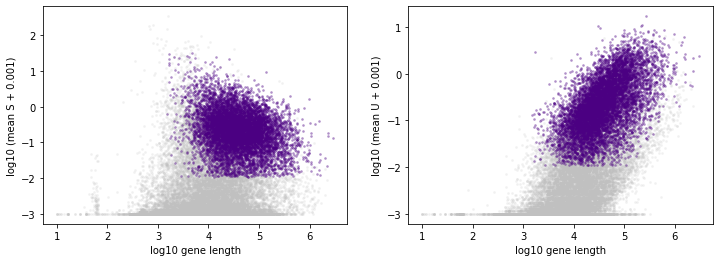

In [8]:
dir_string,dataset_strings = monod.preprocess.construct_batch(loom_filepaths, \
                                             transcriptome_filepath, \
                                             dataset_names, \
                                             attribute_names=attribute_names,\
                                             batch_location='./fits',meta='heart_noisefree',batch_id=1,\
                                             n_genes=2500,exp_filter_threshold=None,cf=cf)

## Inference

Fit the model.


In [9]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 


INFO:root:Sequencing model set to None. All sampling parameters set to null.
INFO:root:Directory ./fits/gg_221119_025_heart_noisefree_1/heart_1k_v2/Bursty_None_1x1 created.
INFO:root:Global inference parameters stored to ./fits/gg_221119_025_heart_noisefree_1/heart_1k_v2/Bursty_None_1x1/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: heart_1k_v2
INFO:root:32285 features observed, 32005 match genome annotations. 31649 were unique.
INFO:root:Gene list extracted from ./fits/gg_221119_025_heart_noisefree_1/genes.csv.
INFO:root:Directory ./fits/gg_221119_025_heart_noisefree_1/heart_1k_v2/diagnostic_figures created.
INFO:root:Search data stored to ./fits/gg_221119_025_heart_noisefree_1/heart_1k_v2/raw.sd.
INFO:root:Starting non-parallelized grid scan.
INFO:root:Non-parallelized grid scan complete.
INFO:root:All grid point data cleaned from disk.
INFO:root:Directory ./fits/gg_221119_025_heart_noisefree_1/heart_1k_v2/Bursty_None_1x1/analysis_figures created.
INFO:root:Ru

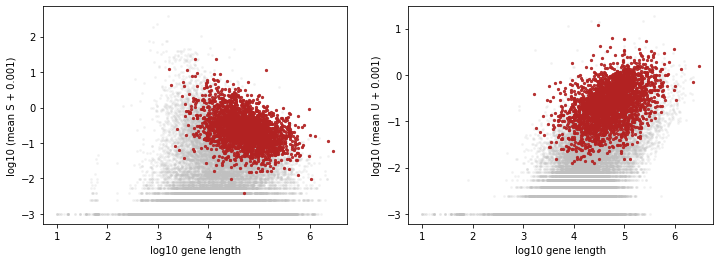

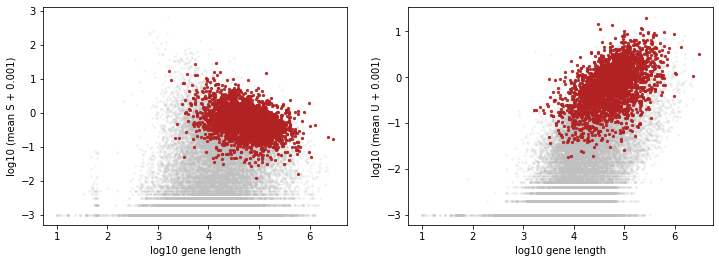

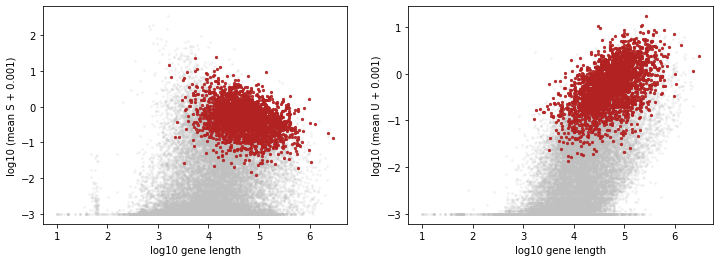

In [10]:
phys_lb = [-1.0, -1.8, -1.8 ]
phys_ub = [4.2, 2.5, 3.5]
samp_lb = [1,1]
samp_ub = [1,1]
gridsize = [1,1]



result_strings = []
for i in range(n_datasets):
    fitmodel = monod.cme_toolbox.CMEModel('Bursty','None')
    inference_parameters = monod.inference.InferenceParameters(phys_lb,phys_ub,samp_lb,samp_ub,gridsize,\
                dataset_strings[i],fitmodel,use_lengths = False,
                gradient_params = {'max_iterations':15,'init_pattern':'moments','num_restarts':1})
    search_data = monod.extract_data.extract_data(loom_filepaths[i], transcriptome_filepath, dataset_names[i],
                dataset_strings[i], dir_string, dataset_attr_names=attribute_names,cf=cf[i])
    full_result_string = inference_parameters.fit_all_grid_points(1,search_data)
    result_strings.append(full_result_string)

## Post-processing

Load in data and do basic QC: test parameter trends and goodness-of-fit.


In [11]:
dataset_names

['heart_1k_v2', 'heart_1k_v3', 'heart_10k_v3']

In [12]:
dir_string

'./fits/gg_221119_025_heart_noisefree_1'

In [13]:
result_strings

['./fits/gg_221119_025_heart_noisefree_1/heart_1k_v2/Bursty_None_1x1/grid_scan_results.res',
 './fits/gg_221119_025_heart_noisefree_1/heart_1k_v3/Bursty_None_1x1/grid_scan_results.res',
 './fits/gg_221119_025_heart_noisefree_1/heart_10k_v3/Bursty_None_1x1/grid_scan_results.res']

INFO:root:Grid scan results loaded from ./fits/gg_221119_025_heart_noisefree_1/heart_1k_v2/Bursty_None_1x1/grid_scan_results.res.
INFO:root:Search data loaded from ./fits/gg_221119_025_heart_noisefree_1/heart_1k_v2/raw.sd.
INFO:root:No rejection statistics have been computed.
INFO:root:Figure stored to ./fits/gg_221119_025_heart_noisefree_1/heart_1k_v2/Bursty_None_1x1/analysis_figures/kldiv.png.
INFO:root:Figure stored to ./fits/gg_221119_025_heart_noisefree_1/heart_1k_v2/Bursty_None_1x1/analysis_figures/gene_distributions_joint.png.
INFO:root:Chi-square computation complete. Rejected 229 genes out of 2500. Runtime: 4.1 seconds.
INFO:root:Computing local Hessian.
INFO:root:Starting parallelized Hessian computation.
INFO:root:Parallelized Hessian computation complete.
INFO:root:Gene 35 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 55 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 122 gives neg

/home/ggorin/projects/monod/src/monod/inference.py:1354: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Figure stored to ./fits/gg_221119_025_heart_noisefree_1/heart_1k_v2/Bursty_None_1x1/analysis_figures/length_dependence.png.
INFO:root:Figure stored to ./fits/gg_221119_025_heart_noisefree_1/heart_1k_v2/Bursty_None_1x1/analysis_figures/parameter_marginals.png.
INFO:root:Directory ./fits/gg_221119_025_heart_noisefree_1/analysis_figures created.
INFO:root:Grid scan results loaded from ./fits/gg_221119_025_heart_noisefree_1/heart_1k_v3/Bursty_None_1x1/grid_scan_results.res.
INFO:root:Search data loaded from ./fits/gg_221119_025_heart_noisefree_1/heart_1k_v3/raw.sd.
INFO:root:No rejection statistics have been computed.
INFO:root:Figure stored to ./fits/gg_221119_025_heart_noisefree_1/heart_1k_v3/Bursty_None_1x1/analysis_figures/kldiv.png.
INFO:root:Figure stored to ./fits/gg_221119_025_heart_noisefree_1/heart_1k_v3/Bursty_None_1x1/analysis_figures/gene_distributions_joint.png.
INFO:root:Chi-square computation complete. Rejected 865 genes out of 2500. Runtime: 7.4 seconds.
INFO:roo

/home/ggorin/projects/monod/src/monod/inference.py:1354: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Figure stored to ./fits/gg_221119_025_heart_noisefree_1/heart_1k_v3/Bursty_None_1x1/analysis_figures/length_dependence.png.
INFO:root:Figure stored to ./fits/gg_221119_025_heart_noisefree_1/heart_1k_v3/Bursty_None_1x1/analysis_figures/parameter_marginals.png.
INFO:root:Directory ./fits/gg_221119_025_heart_noisefree_1/analysis_figures already exists.
INFO:root:Grid scan results loaded from ./fits/gg_221119_025_heart_noisefree_1/heart_10k_v3/Bursty_None_1x1/grid_scan_results.res.
INFO:root:Search data loaded from ./fits/gg_221119_025_heart_noisefree_1/heart_10k_v3/raw.sd.
INFO:root:No rejection statistics have been computed.
INFO:root:Figure stored to ./fits/gg_221119_025_heart_noisefree_1/heart_10k_v3/Bursty_None_1x1/analysis_figures/kldiv.png.
INFO:root:Figure stored to ./fits/gg_221119_025_heart_noisefree_1/heart_10k_v3/Bursty_None_1x1/analysis_figures/gene_distributions_joint.png.
INFO:root:Chi-square computation complete. Rejected 207 genes out of 2500. Runtime: 12.0 secon

/home/ggorin/projects/monod/src/monod/inference.py:1354: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Figure stored to ./fits/gg_221119_025_heart_noisefree_1/heart_10k_v3/Bursty_None_1x1/analysis_figures/length_dependence.png.
INFO:root:Figure stored to ./fits/gg_221119_025_heart_noisefree_1/heart_10k_v3/Bursty_None_1x1/analysis_figures/parameter_marginals.png.
INFO:root:Directory ./fits/gg_221119_025_heart_noisefree_1/analysis_figures already exists.


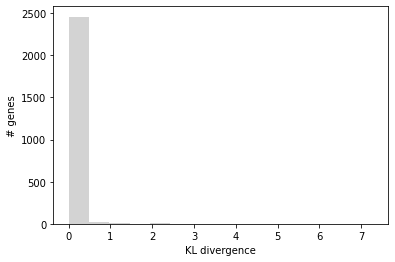

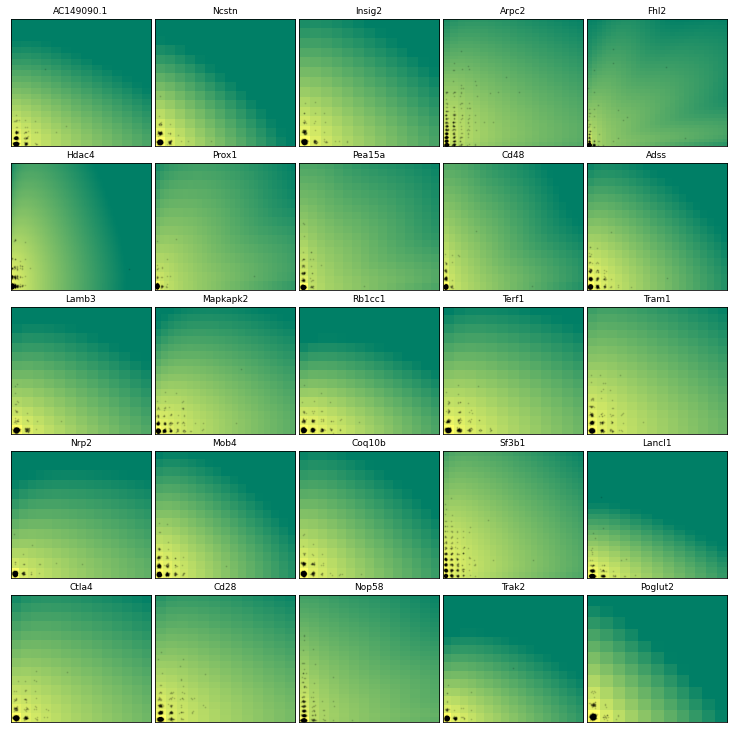

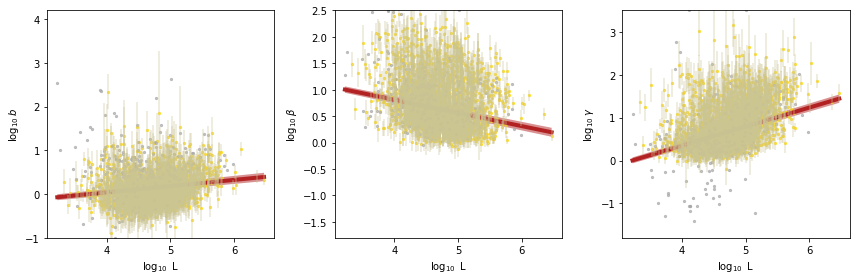

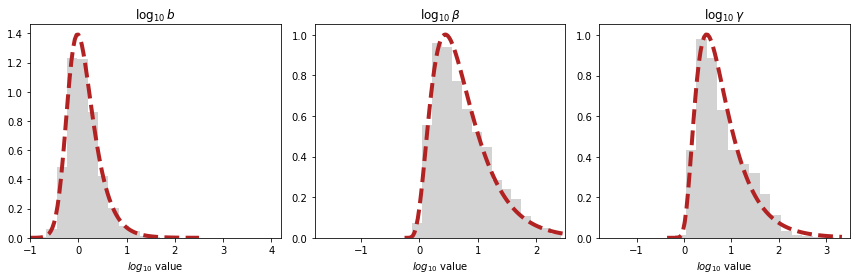

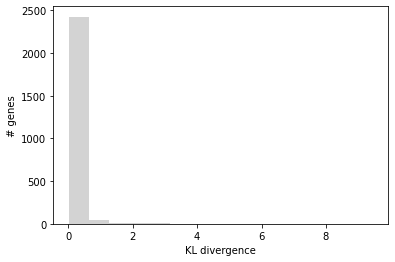

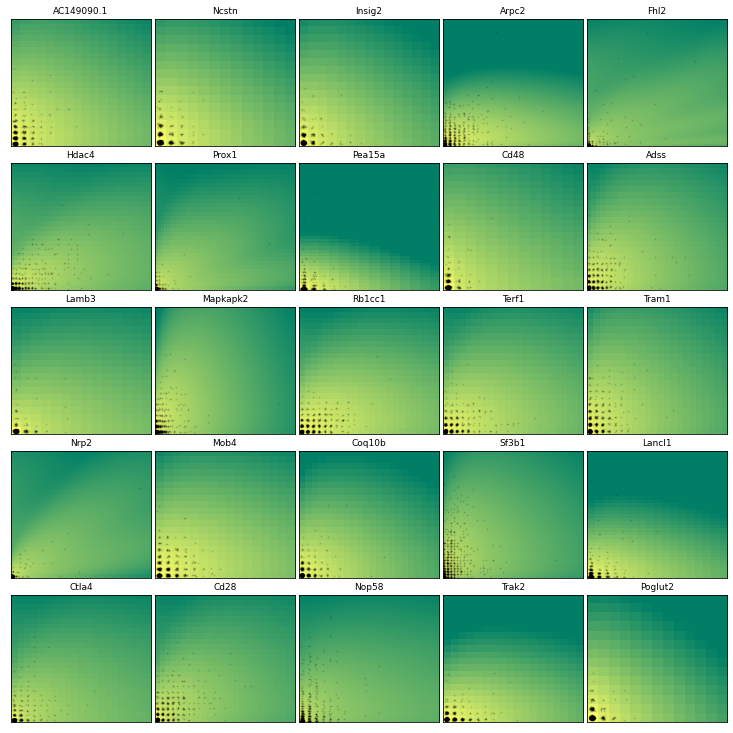

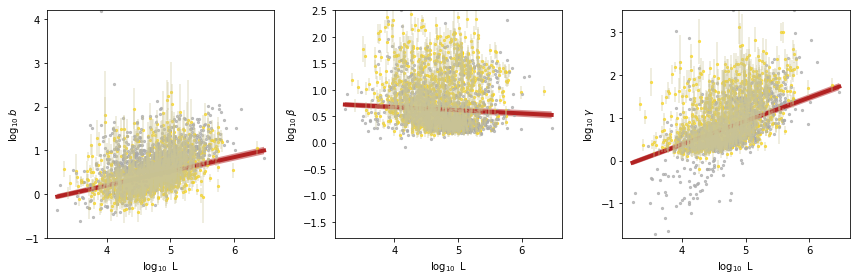

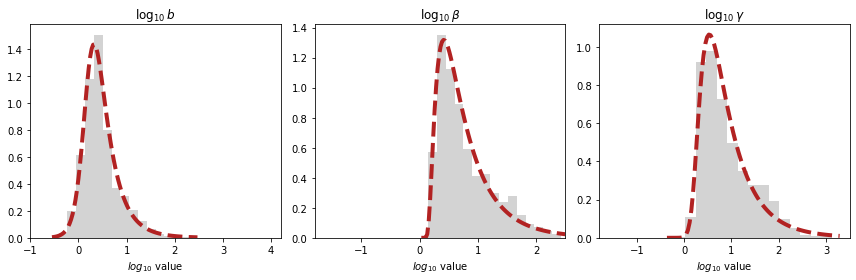

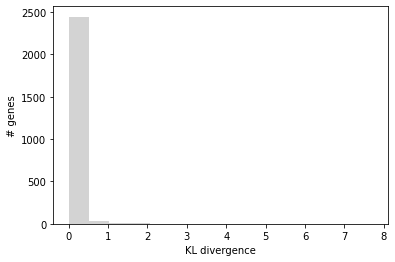

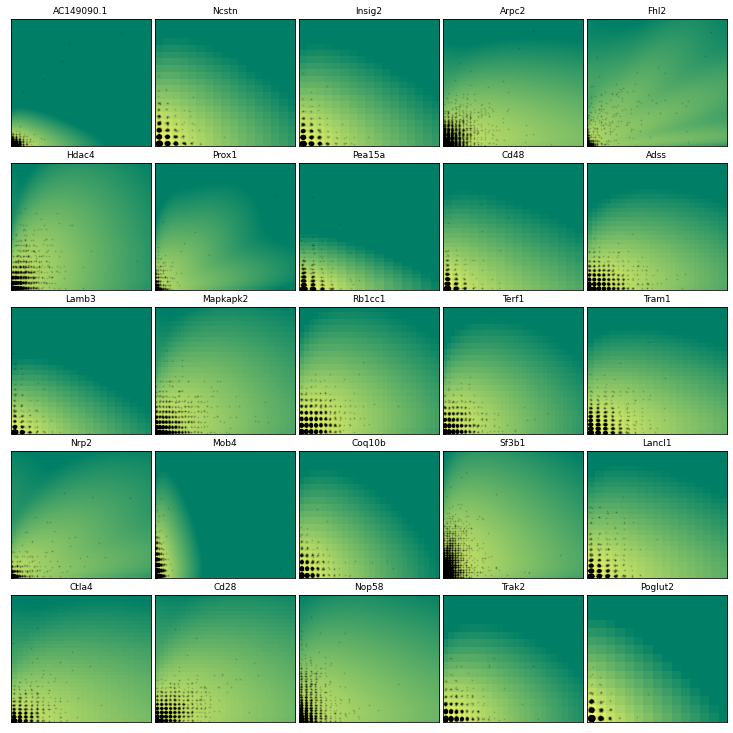

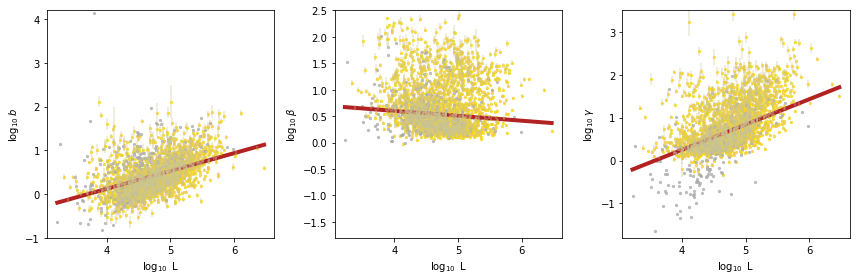

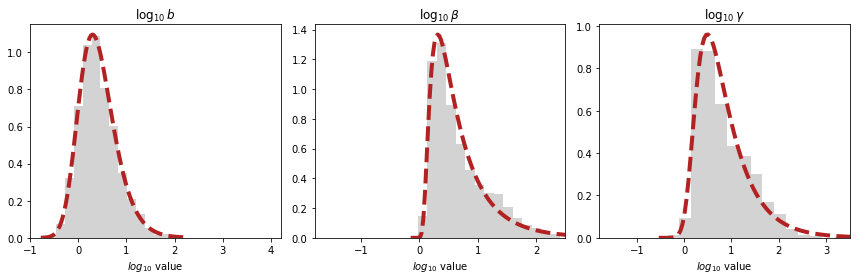

In [14]:
sr_arr = []
sd_arr = []
for i in range(n_datasets):
    sr = monod.analysis.load_search_results(result_strings[i])
    sd = monod.analysis.load_search_data(dir_string+'/'+dataset_names[i]+'/raw.sd')
    sr.find_sampling_optimum()

    fig1,ax1 = plt.subplots(1,1)
    sr.plot_KL(ax1)

    sr.plot_gene_distributions(sd,marg='joint')

    _=sr.chisquare_testing(sd,threshold=0.01)

    sr.compute_sigma(sd,num_cores=60)
    sr.plot_param_L_dep(plot_errorbars=True,plot_fit=True)
    sr.plot_param_marg()
    
    monod.analysis.make_batch_analysis_dir([sr],dir_string)
    sr.update_on_disk()
    
    sr_arr.append(sr)
    sd_arr.append(sd)
